In [3]:
# install
!pip install librosa
!pip install numpy
!pip install pandas
!pip install tqdm
!pip install pydub
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.1 

In [291]:
# import libraries
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from pydub import AudioSegment
import soundfile as sf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import torch
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import seaborn as sn
from sklearn.metrics import confusion_matrix
from torchvision.utils import make_grid
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent
import torchvision
from torchvision import datasets, models, transforms
from os import listdir
import wave
import pylab
import cv2

In [5]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# load audio
dataset_path = "/content/drive/MyDrive/APS360_Group_Project/archive/Data/genres_original"

# function to load an audio file using librosa with pydub as a fallback
def load_audio(file_path, sr=22050):
    try:
        y, sr = librosa.load(file_path, sr=sr)
    except Exception as e:
        try:
            audio = AudioSegment.from_file(file_path)
            audio = audio.set_frame_rate(sr)
            y = np.array(audio.get_array_of_samples(), dtype=np.float32)
            y = y / (2**15)  # normalize to [-1, 1]
        except Exception as e:
            print(f"Failed to load {file_path}: {e}")
            return None, sr
    return y, sr

## Processing Audio Data

In [25]:
# function to process audio (remove silent sections and normalize to [-1, 1])
def load_and_process_audio(file_path, sr=22050, top_db=20):
    y, sr = load_audio(file_path, sr)
    if y is None:
        return None, sr
    # remove silent sections
    y, _ = librosa.effects.trim(y, top_db=top_db)
    # normalize the audio
    y = librosa.util.normalize(y)
    return y, sr

# iterate through each genre directory and process the audio files
def process_dataset(dataset_path=None, file_path=None, genre_files=True):

    if genre_files:
        genres = os.listdir(dataset_path)
        processed_data = []

        for genre in genres:
            genre_path = os.path.join(dataset_path, genre)
            if not os.path.isdir(genre_path):
                continue

            for file_name in tqdm(os.listdir(genre_path)):
                if file_name.endswith(".wav"):
                    file_path = os.path.join(genre_path, file_name)
                    y, sr = load_and_process_audio(file_path)
                    if y is not None:
                        processed_data.append((genre, y, sr))

    else:
        processed_data = []
        genre = ""
        y, sr = load_and_process_audio(file_path)
        if y is not None:
            processed_data.append((genre, y, sr))

    return processed_data

In [26]:
processed_data = process_dataset(dataset_path=dataset_path)

 52%|█████▏    | 52/100 [00:50<00:55,  1.16s/it]<ipython-input-24-dfe2526b494b>:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 53%|█████▎    | 53/100 [00:52<01:03,  1.34s/it]

Failed to load /content/drive/MyDrive/APS360_Group_Project/archive/Data/genres_original/jazz/jazz.00054.wav: Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --

100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


## Feature Extraction - Tempo (BPM), Beat Frames, and Beat Times

In [27]:
# function to extract tempo and beat frames
def extract_tempo_and_beats(processed_data):
    features = []

    for genre, y, sr in processed_data:
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        beat_times = librosa.frames_to_time(beat_frames, sr=sr)
        features.append((genre, tempo, beat_frames, beat_times, y, sr))

    return features

# convert features to a DataFrame
def features_to_dataframe(features):
    df = pd.DataFrame(features, columns=['genre', 'tempo', 'beat_frames', 'beat_times', 'y', 'sr'])
    return df

In [292]:
features = extract_tempo_and_beats(processed_data)

In [293]:
features_df = features_to_dataframe(features)
features_df

,genre,tempo,beat_frames,beat_times,y,sr
0,classical,[95.703125],"[13, 40, 66, 94, 119, 146, 173, 201, 229, 257,...","[0.301859410430839, 0.9287981859410431, 1.5325...","[-0.058436945, -0.0508881, 0.012166963, 0.0250...",22050
1,classical,[161.4990234375],"[7, 24, 40, 55, 72, 89, 106, 122, 137, 153, 16...","[0.16253968253968254, 0.5572789115646258, 0.92...","[-0.03642555, -0.06769168, -0.08203488, -0.099...",22050
2,classical,[103.359375],"[68, 93, 120, 145, 171, 198, 226, 250, 273, 29...","[1.5789569160997732, 2.159455782312925, 2.7863...","[0.04265124, 0.0921659, 0.10755956, 0.10167663...",22050
3,classical,[99.38401442307692],"[9, 36, 63, 92, 119, 144, 171, 198, 224, 253, ...","[0.2089795918367347, 0.8359183673469388, 1.462...","[-0.039123263, -0.0634771, -0.037473485, -0.02...",22050
4,classical,[234.90767045454547],"[14, 25, 36, 47, 57, 68, 79, 90, 100, 111, 122...","[0.3250793650793651, 0.5804988662131519, 0.835...","[0.06686291, 0.09601907, 0.06588169, 0.0644799...",22050
...,...,...,...,...,...,...
994,pop,[107.666015625],"[10, 34, 58, 81, 105, 129, 152, 176, 199, 223,...","[0.23219954648526078, 0.7894784580498866, 1.34...","[0.16674805, 0.14935303, 0.13183594, 0.1317443...",22050
995,pop,[92.28515625],"[93, 122, 150, 178, 207, 235, 264, 292, 321, 3...","[2.159455782312925, 2.8328344671201813, 3.4829...","[0.2557068, 0.2401123, 0.27786255, 0.379364, 0...",22050
996,pop,[99.38401442307692],"[54, 81, 107, 133, 159, 185, 211, 237, 263, 28...","[1.253877551020408, 1.8808163265306121, 2.4845...","[0.049346924, 0.045135498, 0.029785156, 0.0246...",22050
997,pop,[78.30255681818181],"[61, 94, 126, 159, 191, 225, 257, 290, 322, 35...","[1.4164172335600906, 2.182675736961451, 2.9257...","[-0.10747326, -0.0968488, -0.080767564, -0.155...",22050


In [296]:
def graph_combo(df: pd.DataFrame):
    for index, row in tqdm(df.iterrows(), total=len(df), desc='Processing'):
        genre = row['genre']
        y = row['y']  # audio waveform
        sr = row['sr']  # sampling rate
        D = np.abs(librosa.stft(y))

        onset_env = librosa.onset.onset_strength(y=y, sr=sr)

        tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr)

        fig, ax = plt.subplots(2,1,figsize=(5,5),sharex=True,sharey=False)
        plt.subplot(211)
        plt.subplots_adjust(hspace = 0.5)
        librosa.display.specshow(tempogram, sr=sr, x_axis='time', hop_length=512)
        plt.colorbar()
        plt.title(f'Tempogram for genre')
        plt.tight_layout()

        plt.subplot(212)
        librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram for genre')
        plt.tight_layout()

        # manage directory for saving
        base_dir = '/content/drive/MyDrive/APS360_Group_Project/Combo/'
        os.makedirs(base_dir, exist_ok=True)
        save_path = os.path.join(base_dir, genre)
        os.makedirs(save_path, exist_ok=True)  # Ensure genre-specific directory exists

        # save the plot
        plt.savefig(os.path.join(save_path, f'{genre}_{index}.png'))

        plt.close()

In [ ]:
# For the spectrogram, tempogram combo images
graph_combo(features_df[0:int(999/3):1])

Processing: 100%|██████████| 333/333 [16:25<00:00,  2.96s/it]


In [ ]:
graph_combo(features_df[int(999/3):int((999/3)*2):1])

Processing: 100%|██████████| 333/333 [16:07<00:00,  2.91s/it]


In [ ]:
graph_combo(features_df[int((999/3)*2):999:1])                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       agraph_combo(features_df[int((999/3)*2):999:1])

Processing: 100%|██████████| 333/333 [15:41<00:00,  2.83s/it]


In [297]:
from torch.utils.data import DataLoader, SubsetRandomSampler
def get_data_loader(target_classes, batch_size):
  # Specify path to your dataset folder in Google Drive
  data_dir_tempogram = '/content/drive/MyDrive/APS360_Group_Project/tempograms/'
  data_dir_spectrogram = '/content/drive/MyDrive/APS360_Group_Project/spectrograms/'
  data_dir_combo = '/content/drive/MyDrive/APS360_Group_Project/Combo/'

  # normalize images
  transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  # Create dataset instance
  dataset_combo = datasets.ImageFolder(root=data_dir_combo, transform=transform)

  indices = list(range(len(dataset_combo)))
  np.random.shuffle(indices)

  split_60 = int(len(dataset_combo) * 0.6)
  split_20 = int(len(dataset_combo) * 0.2)

  trial_train_indices = indices[:split_60]
  trial_val_indices = indices[split_60:split_60 + split_20]
  trial_test_indices = indices[split_60 + split_20:]

  trial_train_sampler = SubsetRandomSampler(trial_train_indices)
  trial_val_sampler = SubsetRandomSampler(trial_val_indices)
  trial_test_sampler = SubsetRandomSampler(trial_test_indices)

  # Data loaders for spectro/tempogram combo images
  trial_train_loader = DataLoader(dataset_combo, batch_size=batch_size, sampler=trial_train_sampler)
  trial_val_loader = DataLoader(dataset_combo, batch_size=batch_size, sampler=trial_val_sampler)
  trial_test_loader = DataLoader(dataset_combo, batch_size=batch_size, sampler=trial_test_sampler)

  return trial_train_loader, trial_val_loader, trial_test_loader, target_classes

In [298]:
train_loader, val_loader, test_loader, target = get_data_loader(['classical', 'blues', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'], 10)

for i in train_loader:
  print(i[0].shape)
  break

torch.Size([10, 3, 500, 500])


In [36]:
print("Total data points in train loader:", len(train_loader.sampler))
print("Total data points in val loader:", len(val_loader.sampler))
print("Total data points in test loader:", len(test_loader.sampler))

Total data points in train loader: 599
Total data points in val loader: 199
Total data points in test loader: 201


In [299]:
# Check if training data is balanced

import torch
from torch.utils.data import DataLoader, Dataset
from collections import Counter


# Check balance in DataLoader
label_counts = Counter()

for _, label_batch in train_loader:
    label_counts.update(label_batch.tolist())

print(f"Class distribution: {label_counts}")


Class distribution: Counter({6: 73, 0: 66, 1: 65, 2: 64, 9: 57, 4: 56, 3: 56, 7: 55, 5: 54, 8: 53})


## Visualization of Dataset

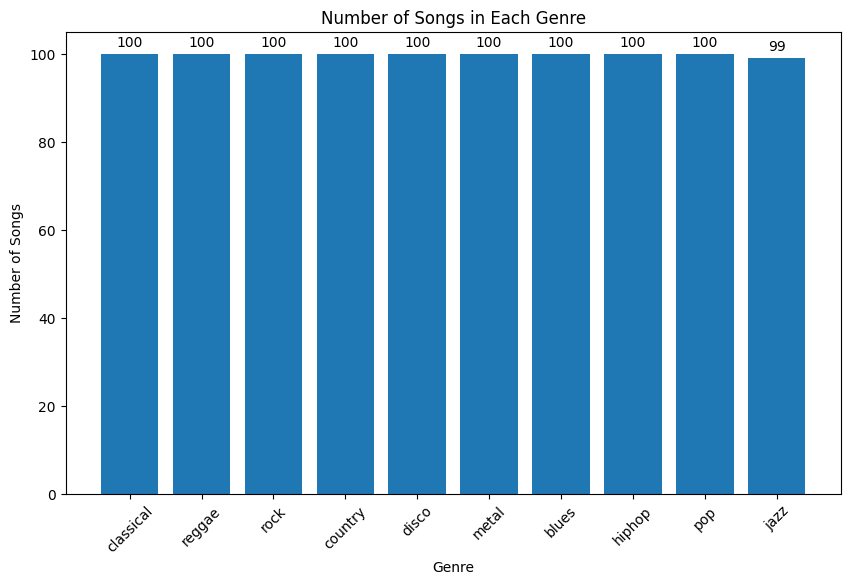

In [ ]:
# Extract genre counts for visualization
genre_counts = features_df['genre'].value_counts()

# Plot the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(genre_counts.index, genre_counts.values)
plt.title('Number of Songs in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45)

# Add labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.show()

## Baseline Model

In [300]:
bpms = {}

genres = ['classical', 'blues', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

base_df = pd.DataFrame()

# create a dataframe with the frist 5 songs of each genre
for i in genres:
  df = features_df[features_df['genre'] == i]
  indices = list(df.index.values)
  df = df.reset_index(drop=True)
  df= df.loc[:4,['genre','tempo', 'beat_frames']]
  df.insert(0, "row", indices[:5], True)
  df.to_dict()
  base_df = pd.concat([base_df,df]).reset_index(drop=True)

genre_tempo = []

for row in base_df.index:
  label = base_df.loc[row, "genre"]
  bpm = base_df.loc[row, "tempo"]
  index = base_df.loc[row, "row"]

  # bpms (dict) contains each enre and all of the bpms of that genre
  if label in bpms:
    bpms[label].append(bpm)
    genre_tempo.append(f"{label}_{index}")
  else:
    bpms[label] = [bpm]
    genre_tempo.append(f"{label}_{index}")

testing_df = pd.DataFrame()
for i in genres:
  test = features_df[features_df['genre'] == i]
  indices = list(test.index.values)
  test = test.reset_index(drop=True)
  test = test.loc[:9,['genre','tempo', 'beat_frames']]
  test.insert(0, "row", indices[:10], True)
  test.to_dict()
  testing_df = pd.concat([testing_df,test]).reset_index(drop=True)

testing_df = testing_df.sample(n=30)
pos_genre = {}

test_indices = testing_df.index.values

for row in test_indices:
  label = testing_df.loc[row, "genre"]
  bpm = testing_df.loc[row, "tempo"]

  for genre in genres:
    # the pos_genres (possible genres) for each song should only be genres that the songs bpm is within range of
    if bpm < max(bpms[genre]) and bpm > min(bpms[genre]):
      if row in pos_genre:
        pos_genre[row].append(genre)
      else:
        pos_genre[row] = [genre]

for i in test_indices:
  if i not in pos_genre:
    pos_genre[i] = ['classical', 'blues', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# define the function to compute MSE between two images
def mse(img1, img2):
   h, w = img1.shape
   diff = cv2.subtract(img1, img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return mse, diff

lowest = float("inf")
diffs = []
pred_genre = ""
correct = 0

for row in test_indices:
  label = testing_df.loc[row, "genre"]
  bpm = testing_df.loc[row, "tempo"]

  for img in pos_genre[row]:
    genre = img.split("_")[0]
    if genre not in pos_genre[row]:
      continue

    for images in os.listdir(f'/content/drive/MyDrive/APS360_Group_Project/Combo/{genre}'):

      img1 = cv2.imread(f'/content/drive/MyDrive/APS360_Group_Project/Combo/{genre}/{images}')
      # load in testing images
      img2 = cv2.imread(f'/content/drive/MyDrive/APS360_Group_Project/Combo/{label}/{label}_{row}0.png')

      #check if images are loaded successfully
      if img1 is None:
          continue
      if img2 is None:
          continue

      # convert the images to grayscale
      img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
      img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

      error, diff = mse(img1, img2)

      if error < lowest:
        lowest = error
        pred_genre = img.split("_")[0]

    if pred_genre == label:
      correct += 1
    lowest = float("inf")

accuracy = (correct/len(testing_df.index))*100
print(f"Accuracy: {accuracy}%")

Accuracy: 43.333333333333336%


## Primary Model

In [8]:
class CNN(nn.Module):
  def __init__(self, input_shape=(500, 500, 3), num_genre=10, hidden_size=50): # num_genre: 10 genres/classes
    super(CNN, self).__init__()
    self.name = "CNN Primary Model"

    # kernel_size = 3 -- helps detect low-level features in spectrogram
    self.conv1 = nn.Conv2d(in_channels=input_shape[2], out_channels=8, kernel_size=3) # input_channel, output_channel, kernel_size
    self.pool = nn.MaxPool2d(kernel_size=(2, 2))
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)

    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

    self.rnn = nn.GRU(53824, hidden_size, batch_first=True)
    self.fc1 = nn.Linear(hidden_size, 120)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(120, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    x = x.view(-1, 53824)
    x, _ = self.rnn(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = torch.relu(x)

    x = self.fc2(x)
    x = x.squeeze(1) # Squeeze the tensor along dimension 1 if its size is 1
    return x

In [9]:
# accuracy function
def evaluate(net, loader):
    correct = 0
    total = 0

    for imgs, labels in loader:

        output = net(imgs)
        #get index with highest prediction
        pred = output.argmax(dim=1)
        # TESTING
        # print("predicted:", labels.view_as(pred))
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [10]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [11]:
# training function
def training(net, batch_size=60, learning_rate=0.001, num_epochs=15, weight_decay=0.001):
    torch.manual_seed(10)  # Set a fixed random seed for reproducibility

    target_classes = ['classical', 'blues', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

    train_loader, val_loader, test_loader, classes = get_data_loader(target_classes, batch_size)

    model = net
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_accuracy = np.zeros(num_epochs)
    val_accuracy = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0

        # Training loop
        for img, label in train_loader:

            # add noise
            # nf = 0.4
            # noisy_img = img + nf * torch.randn(*img.shape)

            # noisy_img = torch.clamp(noisy_img, 0., 1.)

            optimizer.zero_grad() # zero the parameter gradients
            outputs = model(img)

            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)

        # get accuracy
        train_accuracy[epoch] = evaluate(model, train_loader)
        val_accuracy[epoch] = evaluate(model, val_loader)

        print(f"Epoch {epoch}: Train accuracy: {train_accuracy[epoch]:.4f} | Validation accuracy: {val_accuracy[epoch]:.4f}")

        # Save the current model
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    print('Finished Training')
    np.savetxt(f"{model_path}_train_accuracy.csv", train_accuracy)
    np.savetxt(f"{model_path}_val_accuracy.csv", val_accuracy)

In [13]:
batch_size = 100
learning_rate = 1e-4
num_epochs = 150
hidden_size = 50

# Instantiate your CNN model
model = CNN()

# Train the model
training(model, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs)

Epoch 0: Train accuracy: 0.1068 | Validation accuracy: 0.1256
Epoch 1: Train accuracy: 0.0918 | Validation accuracy: 0.0955
Epoch 2: Train accuracy: 0.1152 | Validation accuracy: 0.0854
Epoch 3: Train accuracy: 0.1169 | Validation accuracy: 0.0854
Epoch 4: Train accuracy: 0.1068 | Validation accuracy: 0.1407
Epoch 5: Train accuracy: 0.1002 | Validation accuracy: 0.1206
Epoch 6: Train accuracy: 0.1102 | Validation accuracy: 0.0704
Epoch 7: Train accuracy: 0.1068 | Validation accuracy: 0.0955
Epoch 8: Train accuracy: 0.1285 | Validation accuracy: 0.1106
Epoch 9: Train accuracy: 0.1235 | Validation accuracy: 0.1005
Epoch 10: Train accuracy: 0.1185 | Validation accuracy: 0.1508
Epoch 11: Train accuracy: 0.1386 | Validation accuracy: 0.0955
Epoch 12: Train accuracy: 0.1369 | Validation accuracy: 0.1206
Epoch 13: Train accuracy: 0.1386 | Validation accuracy: 0.1457
Epoch 14: Train accuracy: 0.1486 | Validation accuracy: 0.1709
Epoch 15: Train accuracy: 0.1503 | Validation accuracy: 0.1809
Ep

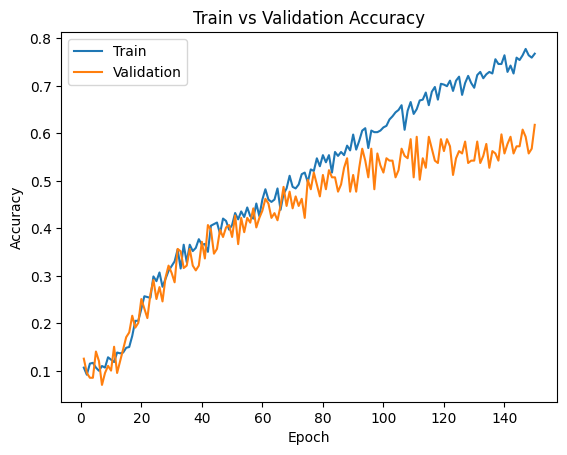

In [15]:
# plotting
def plot_training_curve(path):
    train_accuracy = np.loadtxt("{}_train_accuracy.csv".format(path))
    val_accuracy = np.loadtxt("{}_val_accuracy.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_accuracy) # number of epochs
    plt.plot(range(1,n+1), train_accuracy, label="Train")
    plt.plot(range(1,n+1), val_accuracy, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


plot_training_curve("model_CNN Primary Model_bs100_lr0.0001_epoch149")

In [341]:
target_classes = ['classical', 'blues', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
train_loader, val_loader, test_loader, classes = get_data_loader(target_classes, batch_size=60)
print("Test accuracy:", evaluate(model, test_loader))

Test accuracy: 0.7960199004975125


# **User Input**

In [114]:
def graph_combo_input(df: pd.DataFrame):
    for index, row in tqdm(df.iterrows(), total=len(df), desc='Processing'):
        genre = row['genre']
        y = row['y']  # audio waveform
        sr = row['sr']  # sampling rate
        D = np.abs(librosa.stft(y))

        onset_env = librosa.onset.onset_strength(y=y, sr=sr)

        tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr)

        fig, ax = plt.subplots(2,1,figsize=(5,5),sharex=True,sharey=False)
        plt.subplot(211)
        plt.subplots_adjust(hspace = 0.5)
        librosa.display.specshow(tempogram, sr=sr, x_axis='time', hop_length=512)
        plt.colorbar()
        plt.title(f'Tempogram for genre')
        plt.tight_layout()

        plt.subplot(212)
        librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram for genre')
        plt.tight_layout()

        # manage directory for saving
        base_dir = '/content/drive/MyDrive/APS360_Group_Project/input'
        os.makedirs(base_dir, exist_ok=True)
        save_path = os.path.join(base_dir, "images")
        os.makedirs(save_path, exist_ok=True)  # Ensure directory exists

        # save the plot
        plt.savefig(os.path.join(save_path, f'input{index}.png'))

        plt.close()

from torch.utils.data import DataLoader, SubsetRandomSampler
def get_data_loader_input(target_classes, batch_size):
  # Specify path to your dataset folder in Google Drive
  data_dir_combo = '/content/drive/MyDrive/APS360_Group_Project/input'

  # normalize images
  transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  # Create dataset instance

  dataset_combo = datasets.ImageFolder(root=data_dir_combo, transform=transform)

  trial_loader = DataLoader(dataset_combo, batch_size=batch_size)

  return trial_loader, target_classes


In [115]:
def run_prediction(file_path, target_classes, batch_size):
    processed = process_dataset(file_path=file_path, genre_files=False)
    features = extract_tempo_and_beats(processed)
    df = features_to_dataframe(features)

    graph_combo_input(df)

    trial_loader, target_classes = get_data_loader_input(target_classes, batch_size=batch_size)

    for imgs, labels in trial_loader:
        output = model(imgs)
        pred = output.argmax(dim=1)

        genre_mapping = {0: 'classical', 1: 'blues', 2: 'country', 3: 'disco', 4:'hiphop', 5:'jazz', 6:'metal', 7:'pop', 8:'reggae', 9:'rock'}

        for elem in pred:
            predicted_genre = genre_mapping.get(elem.item(), 'Unknown Genre')
            print("\n", predicted_genre)


In [288]:
import ipywidgets as widgets
from IPython.display import display
import shutil
import os

# Create an upload widget
upload = widgets.FileUpload(accept='.wav,.mp3', multiple=False)

# Directory to store the uploaded file
upload_dir = '/content/uploaded_files'
os.makedirs(upload_dir, exist_ok=True)

def on_upload_change(change):
    global input_file_path
    uploaded_file = list(upload.value.values())[0]
    file_name = uploaded_file['metadata']['name']
    content = uploaded_file['content']

    # Save the file to the specified directory
    input_file_path = os.path.join(upload_dir, file_name)
    with open(input_file_path, 'wb') as f:
        f.write(content)

    print(f'File "{file_name}" has been saved to "{input_file_path}".')

upload.observe(on_upload_change, names='value')
display(upload)

FileUpload(value={}, accept='.wav,.mp3', description='Upload')

File "CaliforniaGurls - 15 sec.wav" has been saved to "/content/uploaded_files/CaliforniaGurls - 15 sec.wav".


In [289]:
print(input_file_path)

/content/uploaded_files/CaliforniaGurls - 15 sec.wav


In [290]:
file_path = input_file_path
run_prediction(file_path=file_path, target_classes=target_classes, batch_size=1)

Processing: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


 pop
